In [1]:
from mxnet import init
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import nd
from mxnet import autograd
from mxnet import image
import numpy as np
import pickle as p
import mxnet as mx
from time import time
import matplotlib.pyplot as plt
ctx = mx.gpu()

In [2]:
def load_cifar(route = '/home/sinyer/python/data/cifar-10-batches-py', train_num = 50000, test_num = 10000):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    train_pic = train_pic[:train_num].astype('float32')/255
    train_label = train_label[:train_num].astype('float32')
    test_pic = test_pic[:test_num].astype('float32')/255
    test_label = test_label[:test_num].astype('float32')
    return train_pic, train_label, test_pic, test_label

train_pic, train_label, test_pic, test_label = load_cifar()

In [3]:
batch_size = 128
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label), batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label), batch_size, shuffle=False)

In [4]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(data_iterator, net, ctx):
    acc = 0.
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

class Residual(nn.Block):
    def __init__(self, channels, same_shape=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1, strides=strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=strides)
    def forward(self, x):
        out = nd.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return nd.relu(out + x)

class ResNet(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        with self.name_scope(): 
            b1 = nn.Conv2D(16, kernel_size=3, strides=1, padding=1)
            b2 = nn.Sequential()
            for _ in range(8):
                b2.add(Residual(16))
            b3 = nn.Sequential()
            b3.add(Residual(32, same_shape=False))
            for _ in range(7):
                b3.add(Residual(32))
            b4 = nn.Sequential()
            b4.add(Residual(64, same_shape=False))
            for _ in range(7):
                b4.add(Residual(64))
            b5 = nn.Sequential()
            b5.add(nn.AvgPool2D(pool_size=3),nn.Dense(num_classes))
            self.net = nn.Sequential()
            self.net.add(b1, b2, b3, b4, b5)
    def forward(self, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
        return out

In [5]:
net = ResNet(10)
net.initialize(ctx=ctx, init=init.Xavier())
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0.9, 'wd': 5e-4})

E 0; L 2.440846; Tr_acc 0.112908; Te_acc 0.149031; T 43.727409
E 5; L 0.992694; Tr_acc 0.649253; Te_acc 0.616792; T 29.377880
E 10; L 0.560019; Tr_acc 0.804632; Te_acc 0.686017; T 29.454799
E 15; L 0.271208; Tr_acc 0.906909; Te_acc 0.819027; T 29.364724
E 20; L 0.173102; Tr_acc 0.939114; Te_acc 0.827729; T 29.519886
E 25; L 0.053910; Tr_acc 0.984515; Te_acc 0.856408; T 29.428388
E 30; L 0.002960; Tr_acc 0.999940; Te_acc 0.858188; T 29.487255
E 35; L 0.002385; Tr_acc 0.999960; Te_acc 0.859276; T 29.354192


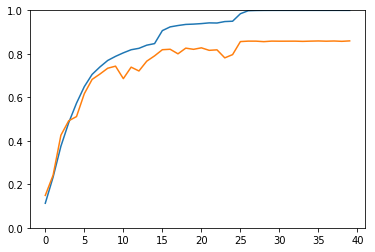

In [6]:
epochs = 40

a = []
b = []
for epoch in range(epochs):
    if epoch == 15:
        trainer.set_learning_rate(0.02)
    if epoch == 25:
        trainer.set_learning_rate(0.005)
    if epoch == 30:
        trainer.set_learning_rate(0.001)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(l).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%5 == 0:
        print("E %d; L %f; Tr_acc %f; Te_acc %f; T %f" % (epoch, train_loss / batch, train_acc / batch, test_acc, time() - start))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0,1)
plt.show()